# STARTING CODE

## LIBRARIES

In [ ]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.32
    Uninstalling SQLAlchemy-2.0.32:
      Successfully uninstalled SQLAlchemy-2.0.32
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.53 which is incompatible.


In [ ]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import obspy
from obspy.signal.detrend import polynomial
from scipy.signal import find_peaks

## FUNCTIONS

In [ ]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s)
        # pre-sorting of locals min based on relative position with respect to s_mid
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid
        lmax = lmax[s[lmax]>s_mid]

    # global min of dmin-chunks of locals min
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]

    return lmin,lmax

# BPM

/usr/local/lib/python3.10/dist-packages/obspy/signal/detrend.py:110: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyval(np.polyfit(x, data, deg=order), x)


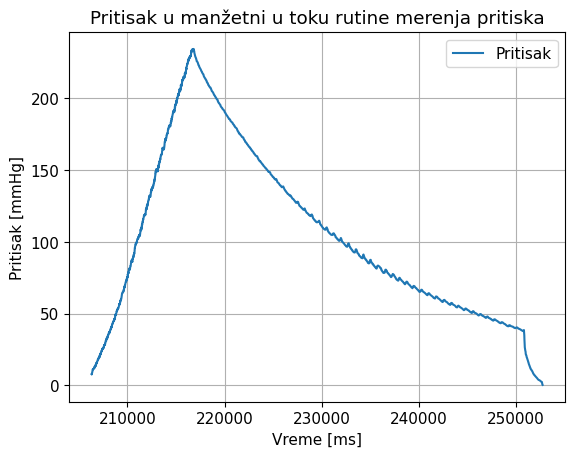

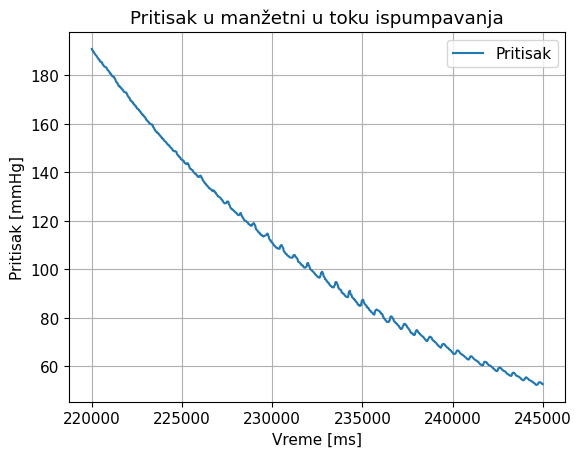

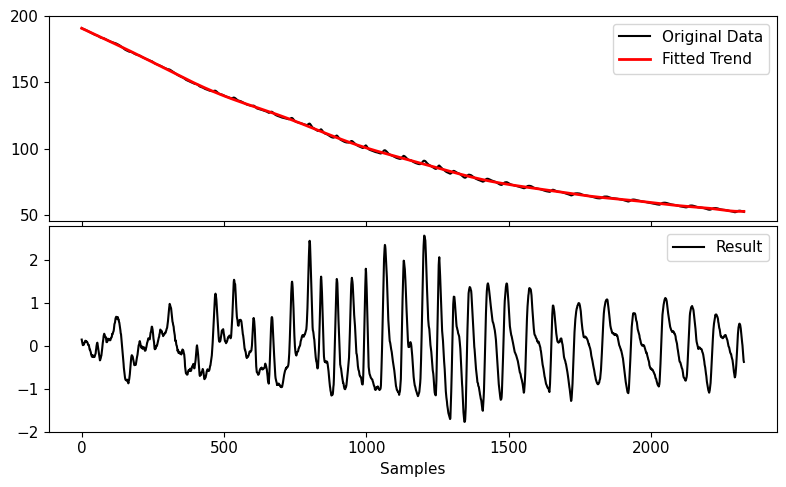

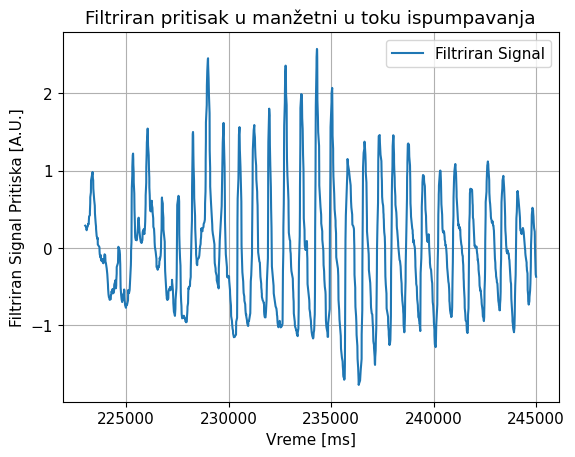

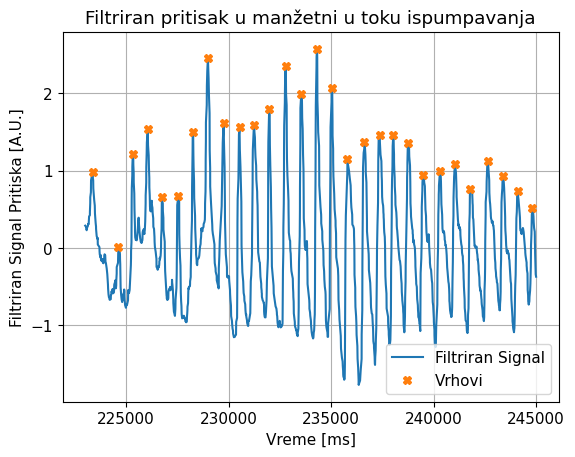

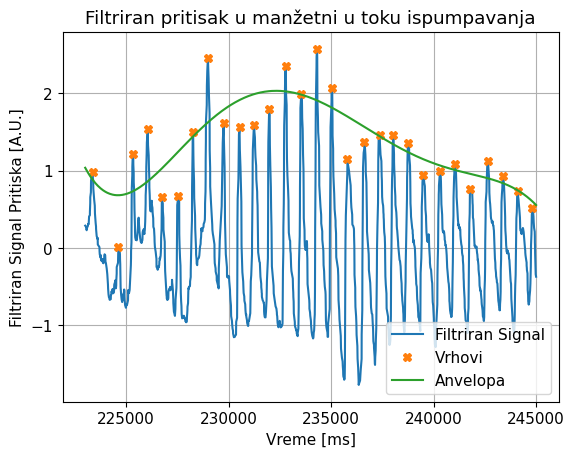

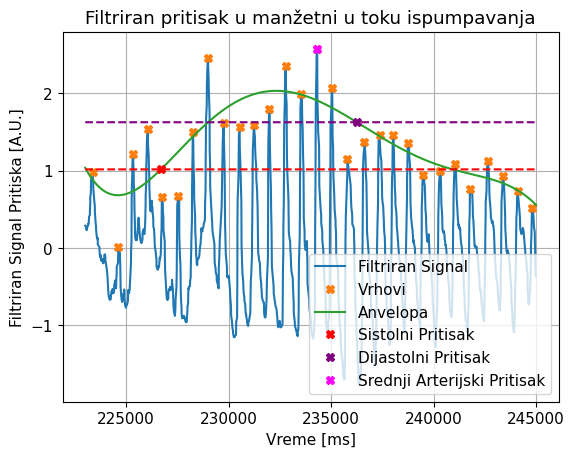

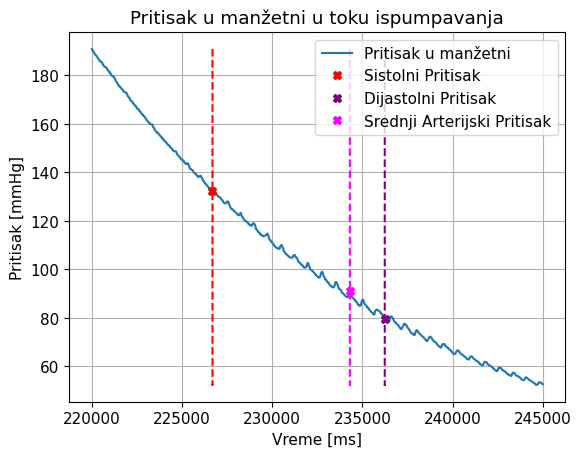

Measured blood pressure is:
SYS: 132
DIA: 79
MAP: 91
HR: 78


In [ ]:
data_path = 'FullMeasurement1.csv'
plt.rcParams.update({'font.size': 11})

# Arrays using for storing the raw data from the CSV file
bpm_raw   = []
aux_raw   = []
bpm_time  = []
aux_time  = []
ppg_raw   = []
ppg_time  = []
ecg_raw   = []
ecg_time  = []

# Flag used for skipping the header in the data file
header = True

# Variables for keeping the start and stop time for the BPM
t_start = 0
t_stop  = 0

t_dia_ppg = 0
t_sys_aux = 0
t_dia_bpm = 0
t_sys_bpm = 0

hr_ppg = 0
hr_aux = 0
hr_bpm = 0

# Getting the data out of the file and into the variables
with open(data_path, 'r', newline = '') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        if header == True:
            header = False
        else:
            if row[0] != '':
              ecg_raw.append(int(row[0]))
              ecg_time.append(int(row[1]))
            if row[2] != '':
              bpm_raw.append(float(row[2]))
              bpm_time.append(int(row[3]))
            if row[4] != '':
              aux_raw.append(int(row[4]))
              aux_time.append(int(row[5]))
            if row[6] != '':
              ppg_raw.append(int(row[6]))
              ppg_time.append(int(row[7]))

# Filtering the pressure signal my moving an average window across the data
window_size = 10
bpm_filtered_data = []
bpm_filtered_time = []
for i in range(window_size, len(bpm_raw)):
  bpm_filtered_data.append(sum(bpm_raw[i : i + window_size]) / window_size)
bpm_filtered_time = bpm_time[window_size :]

# Figure 1 - Pressure signal during the whole pressure measurement
fig_bpm1, ax_bpm1 = plt.subplots()
ax_bpm1.plot(bpm_filtered_time[150 :], bpm_filtered_data[150 :], label = 'Pritisak')
ax_bpm1.set(xlabel = 'Vreme [ms]', ylabel = 'Pritisak [mmHg]', title = 'Pritisak u manžetni u toku rutine merenja pritiska')
ax_bpm1.legend()
ax_bpm1.grid(which='both')

# Deflation bpm signals
t_deflation_start = 220000
t_deflation_stop  = 245000
bpm_deflation_data = []
bpm_deflation_time = []
# Extracting the deflation part of the BPM signals
for i in range(0, len(bpm_filtered_data)):
    if bpm_filtered_time[i] >= t_deflation_start and bpm_filtered_time[i] <= t_deflation_stop:
      bpm_deflation_data.append(bpm_filtered_data[i])
      bpm_deflation_time.append(bpm_filtered_time[i])

# Figure 2 - Pressure signal during the deflation portion of the measurement
fig_bpm2, ax_bpm2 = plt.subplots()
ax_bpm2.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pritisak')
ax_bpm2.set(xlabel = 'Vreme [ms]', ylabel = 'Pritisak [mmHg]', title = 'Pritisak u manžetni u toku ispumpavanja')
ax_bpm2.legend()
ax_bpm2.grid(which='both')

# Detrending the pressure function
obspy_data = obspy.read()[0].filter('highpass', freq = 1)
obspy_data.data = np.array(bpm_deflation_data)
trend_data = obspy_data.data
trend_function = polynomial(trend_data, order = 20, plot = True)

t_bpm_analysis_start  = 223000
t_bpm_analysis_stop   = 245000
bpm_analysis_data     = []
bpm_analysis_time     = []

for i in range(0, len(bpm_deflation_time)):
  if bpm_deflation_time[i] >= t_bpm_analysis_start and bpm_deflation_time[i] <= t_bpm_analysis_stop:
    bpm_analysis_data.append(trend_function[i])
    bpm_analysis_time.append(bpm_deflation_time[i])

# Figure 3 - Detrended pressure signal during the deflation portion of the measurement
fig_bpm3, ax_bpm3 = plt.subplots()
ax_bpm3.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtriran Signal')
ax_bpm3.set(xlabel = 'Vreme [ms]', ylabel = 'Filtriran Signal Pritiska [A.U.]', title = 'Filtriran pritisak u manžetni u toku ispumpavanja')
ax_bpm3.legend()
ax_bpm3.grid(which='both')

# Pressure Signal Peak Detection
bpm_peaks_ids, aux_peak_properties = find_peaks(bpm_analysis_data, height = 0, distance = 30, prominence = (0.5, None))
bpm_peaks_data = []
bpm_peaks_time = []
# Saving the found peaks to arrazs
for peak in bpm_peaks_ids:
  bpm_peaks_data.append(bpm_analysis_data[peak])
  bpm_peaks_time.append(bpm_analysis_time[peak])

# Figure 4 - Detrended pressure signal with peak detection
fig_bpm4, ax_bpm4 = plt.subplots()
ax_bpm4.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtriran Signal')
ax_bpm4.plot(bpm_peaks_time, bpm_peaks_data, 'X', label = 'Vrhovi')
ax_bpm4.set(xlabel = 'Vreme [ms]', ylabel = 'Filtriran Signal Pritiska [A.U.]', title = 'Filtriran pritisak u manžetni u toku ispumpavanja')
ax_bpm4.legend(loc = 4)
ax_bpm4.grid(which='both')

# Estimated Signal Envlope
# Polynomial fit on the peaks
bpm_envelope_coefs = np.polyfit(bpm_peaks_time, bpm_peaks_data, deg = 5)
bpm_envelope = []
# Calculating the signal based on the polyfit coefs
for i in range(0, len(bpm_analysis_time)):
  dot = 1
  val = 0
  # Calculate the envelope point using all of the coefficients
  for j in range(0, len(bpm_envelope_coefs)):
    val += dot * bpm_envelope_coefs[len(bpm_envelope_coefs) - j - 1]
    dot = dot * bpm_analysis_time[i]
  # Add the val to the array
  bpm_envelope.append(val)

# Figure 5 - Detrended pressure signal with peaks with a fitted envelope signal
fig_bpm5, ax_bpm5 = plt.subplots()
ax_bpm5.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtriran Signal')
ax_bpm5.plot(bpm_peaks_time, bpm_peaks_data, 'X', label = 'Vrhovi')
ax_bpm5.plot(bpm_analysis_time, bpm_envelope, label = 'Anvelopa')
ax_bpm5.set(xlabel = 'Vreme [ms]', ylabel = 'Filtriran Signal Pritiska [A.U.]', title = 'Filtriran pritisak u manžetni u toku ispumpavanja')
ax_bpm5.legend(loc = 4)
ax_bpm5.grid(which='both')

# Estimating the SYS and DIA pressure from the signal
bpm_max_peak = max(bpm_envelope)
sys_height = 0.5 * bpm_max_peak
dia_height = 0.8 * bpm_max_peak

bpm_sys_idx = 0
bpm_dia_idx = 0
bpm_sys_time = 0
bpm_dia_time = 0
bpm_closest_dia = 100
bpm_closest_sys = 100

bpm_map_fig = max(bpm_envelope)
bpm_map_time = bpm_analysis_time[bpm_envelope.index(bpm_map_fig)]

for i in range(0, len(bpm_envelope)):
  # We're looking for SYS before MAP
  if bpm_analysis_time[i] < bpm_map_time:
    # Check whether we're closer to the value than the previous one
    if abs(bpm_envelope[i] - sys_height) < bpm_closest_sys:
      bpm_closest_sys = abs(bpm_envelope[i] - sys_height)
      bpm_sys_time = bpm_analysis_time[i]
  else:
    # Do the same thing after MAP for the DIA pressure
    if abs(bpm_envelope[i] - dia_height) < bpm_closest_dia:
      bpm_closest_dia = abs(bpm_envelope[i] - dia_height)
      bpm_dia_time = bpm_analysis_time[i]

bpm_map = 0
t_bpm_map = bpm_peaks_time[bpm_peaks_data.index(max(bpm_peaks_data))]

for i in range(0, len(bpm_deflation_time) - 1):
  if bpm_deflation_time[i] <= t_bpm_map and bpm_deflation_time[i + 1] > t_bpm_map:
    bpm_map = bpm_deflation_data[i]
    break

# Figure 6 - Detrended pressure signal with peaks with a fitted envelope signal and lines for the SYS and DIA pressures
fig_bpm6, ax_bpm6 = plt.subplots()
ax_bpm6.plot(bpm_analysis_time, bpm_analysis_data, label = 'Filtriran Signal')
ax_bpm6.plot(bpm_peaks_time, bpm_peaks_data, 'X', label = 'Vrhovi')
ax_bpm6.plot(bpm_analysis_time, bpm_envelope, label = 'Anvelopa')
ax_bpm6.plot(bpm_analysis_time, np.ones(len(bpm_analysis_time)) * sys_height, '--', color = 'red')
ax_bpm6.plot(bpm_analysis_time, np.ones(len(bpm_analysis_time)) * dia_height, '--', color = 'purple')
ax_bpm6.plot(bpm_sys_time, sys_height, 'X', color = 'red', linewidth = 18, label = 'Sistolni Pritisak')
ax_bpm6.plot(bpm_dia_time, dia_height, 'X', color = 'purple', linewidth = 18, label = 'Dijastolni Pritisak')
ax_bpm6.plot(t_bpm_map, max(bpm_peaks_data), 'X', color = 'magenta', linewidth = 18, label = 'Srednji Arterijski Pritisak')
ax_bpm6.set(xlabel = 'Vreme [ms]', ylabel = 'Filtriran Signal Pritiska [A.U.]', title = 'Filtriran pritisak u manžetni u toku ispumpavanja')
ax_bpm6.legend(loc = 4)
ax_bpm6.grid(which='both')

# Calculating the actual pressure values by using the time of the previously found signals
bpm_sys_val = 0
bpm_dia_val = 0

for i in range(0, len(bpm_deflation_data) - 1):
  if bpm_deflation_time[i] <= bpm_sys_time and bpm_deflation_time[i + 1] > bpm_sys_time:
    bpm_sys_val = bpm_deflation_data[i]
  if bpm_deflation_time[i] <= bpm_dia_time and bpm_deflation_time[i + 1] > bpm_dia_time:
    bpm_dia_val = bpm_deflation_data[i]

# Figure 7 - Pressure signal with time markers for reading the SYS, DIA and MAP
fig_bpm7, ax_bpm7 = plt.subplots()
ax_bpm7.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pritisak u manžetni')
ax_bpm7.plot(np.ones(len(bpm_deflation_time)) * bpm_sys_time, bpm_deflation_data, '--', color = 'red')
ax_bpm7.plot(np.ones(len(bpm_deflation_time)) * bpm_dia_time, bpm_deflation_data, '--', color = 'purple')
ax_bpm7.plot(np.ones(len(bpm_deflation_time)) * t_bpm_map, bpm_deflation_data, '--', color = 'magenta')
ax_bpm7.plot(bpm_sys_time, bpm_sys_val, 'X', color = 'red', label = 'Sistolni Pritisak')
ax_bpm7.plot(bpm_dia_time, bpm_dia_val, 'X', color = 'purple', label = 'Dijastolni Pritisak')
ax_bpm7.plot(t_bpm_map, bpm_map, 'X', color = 'magenta', label = 'Srednji Arterijski Pritisak')
ax_bpm7.set(xlabel = 'Vreme [ms]', ylabel = 'Pritisak [mmHg]', title = 'Pritisak u manžetni u toku ispumpavanja')
ax_bpm7.legend()
ax_bpm7.grid(which='both')

plt.show()

print('Measured blood pressure is:')
print('SYS: ' + str(int(bpm_sys_val)))
print('DIA: ' + str(int(bpm_dia_val)))
print('MAP: ' + str(int(bpm_map)))
bpm_hr = 60000 * (len(bpm_peaks_data) - 1) / (bpm_peaks_time[-1] - bpm_peaks_time[0])
print('HR: ' + str(int(bpm_hr)))

save_figures = False

if save_figures == True:
  fig_bpm1.savefig("BPM_fig1_PritisakUManzetniUTokuMerenja.png", dpi = 250, bbox_inches='tight')
  fig_bpm2.savefig("BPM_fig2_PritisakUTokuIspumpavanja.png", dpi = 250, bbox_inches='tight')
  fig_bpm3.savefig("BPM_fig3_PritisakUTokuIspumpavanja-Filtriran.png", dpi = 250, bbox_inches='tight')
  fig_bpm4.savefig("BPM_fig4_PritisakUTokuIspumpavanja-Filtriran-Pikovi.png", dpi = 250, bbox_inches='tight')
  fig_bpm5.savefig("BPM_fig5_PritisakUTokuIspumpavanja-Filtriran-Pikovi-Anvelopa.png", dpi = 250, bbox_inches='tight')
  fig_bpm6.savefig("BPM_fig6_PritisakUTokuIspumpavanja-Filtriran-Pikovi-Anvelopa-SYS-DIA-MAP.png", dpi = 250, bbox_inches='tight')
  fig_bpm7.savefig("BPM_fig7_PritisakUTokuIspumpavanja-SYS-DIA-MAP.png", dpi = 250, bbox_inches='tight')


# AUX

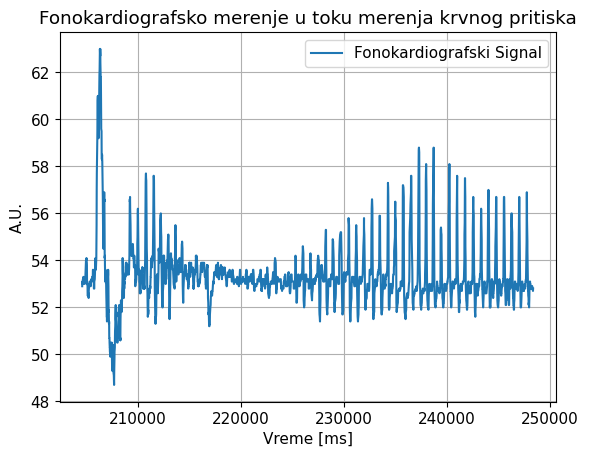

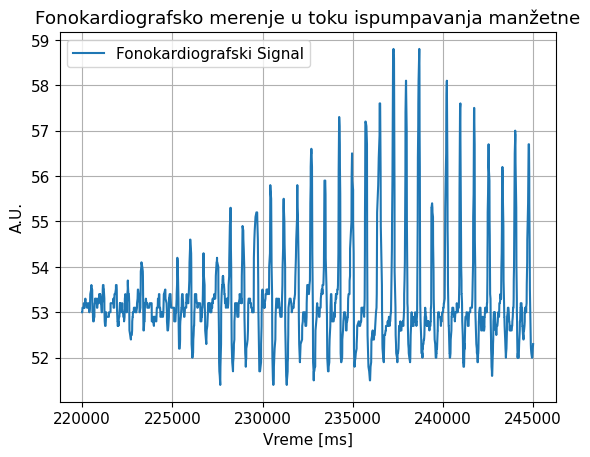

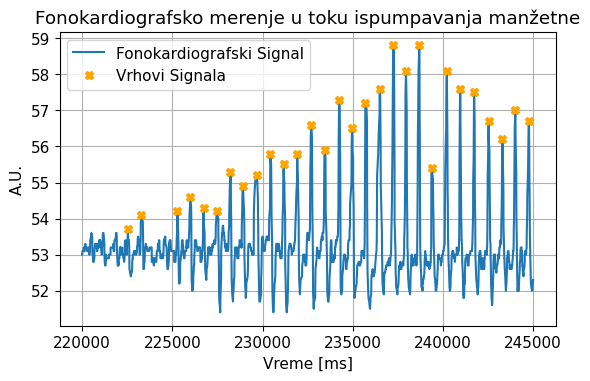

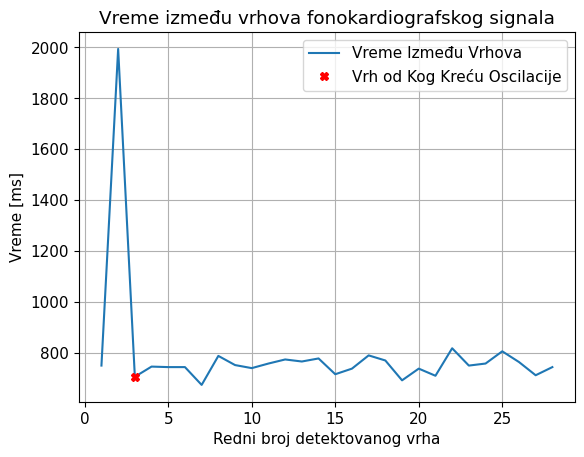

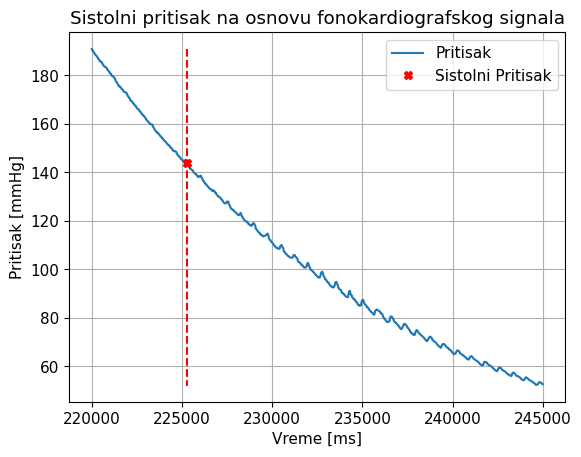

AUX signal results
AUX HR measured during deflation: 80
AUX SYS pressure measurement: 143


In [ ]:
#AUX signal analysis
window_size = 10
aux_filtered_data = []
aux_filtered_time = aux_time[window_size :]

for i in range(window_size, len(aux_raw)):
  aux_filtered_data.append(sum(aux_raw[i : i + window_size]) / window_size)

# Figure 1 - Aux signal during pressure measurement
fig_aux1, ax_aux1 = plt.subplots()
ax_aux1.plot(aux_filtered_time[: -500], aux_filtered_data[: -500], label = 'Fonokardiografski Signal')
ax_aux1.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Fonokardiografsko merenje u toku merenja krvnog pritiska')
ax_aux1.legend()
ax_aux1.grid(which='both')

aux_deflation_data = []
aux_deflation_time = []

for i in range(0, len(aux_filtered_data)):
    if aux_filtered_time[i] >= t_deflation_start and aux_filtered_time[i] <= t_deflation_stop:
      aux_deflation_data.append(aux_filtered_data[i])
      aux_deflation_time.append(aux_filtered_time[i])


# Figure 2 - Aux signal during deflation
fig_aux2, ax_aux2 = plt.subplots()
ax_aux2.plot(aux_deflation_time, aux_deflation_data, label = 'Fonokardiografski Signal')
ax_aux2.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Fonokardiografsko merenje u toku ispumpavanja manžetne')
ax_aux2.legend()
ax_aux2.grid(which='both')

# AUX signal peak detection
aux_peaks_ids, aux_peak_properties = find_peaks(aux_deflation_data, height = 0, distance = 30, prominence = (1.0, None))
# Arrays for storing the peaks
aux_peaks_data = []
aux_peaks_time = []
# Getting the peak data into the arrays
for peak in aux_peaks_ids:
  aux_peaks_data.append(aux_deflation_data[peak])
  aux_peaks_time.append(aux_deflation_time[peak])

# Figure 3 - Aux signal during deflation with peak detection
fig_aux3, ax_aux3 = plt.subplots()
ax_aux3.set_aspect(2000)
ax_aux3.plot(aux_deflation_time, aux_deflation_data, label = 'Fonokardiografski Signal')
ax_aux3.plot(aux_peaks_time, aux_peaks_data, 'X', color = 'orange', label = 'Vrhovi Signala')
ax_aux3.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Fonokardiografsko merenje u toku ispumpavanja manžetne')
ax_aux3.legend()
ax_aux3.grid(which='both')

# Calculating the delta time between detected pulses
aux_beats_delta = []

for i in range(1, len(aux_peaks_data)):
  aux_beats_delta.append(aux_peaks_time[i] - aux_peaks_time[i - 1])

# Figure 4 - Time between consecutive pulses (peaks)
fig_aux4, ax_aux4 = plt.subplots()
ax_aux4.plot(np.linspace(start = 1, stop = len(aux_beats_delta), num = len(aux_beats_delta)), aux_beats_delta, label = 'Vreme Između Vrhova')
ax_aux4.plot(3, aux_beats_delta[2], 'X', color = 'red', label = 'Vrh od Kog Kreću Oscilacije')
ax_aux4.set(xlabel = 'Redni broj detektovanog vrha', ylabel = 'Vreme [ms]', title = 'Vreme između vrhova fonokardiografskog signala')
ax_aux4.legend()
ax_aux4.grid(which='both')

# Calculating the SYS pressure based on the AUX signal
aux_sys = 0
for i in range(0, len(bpm_deflation_data) - 1):
  if bpm_deflation_time[i] <= aux_peaks_time[2] and bpm_deflation_time[i + 1] > aux_peaks_time[2]:
    aux_sys = bpm_deflation_data[i]

# Figure 5 - Finding the SYS pressure based on the AUX signal
fig_aux5, ax_aux5 = plt.subplots()
ax_aux5.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pritisak')
ax_aux5.plot(np.ones(len(bpm_deflation_time)) * aux_peaks_time[2], bpm_deflation_data, '--', color = 'red')
ax_aux5.plot(aux_peaks_time[2], aux_sys, 'X', color = 'red', label = 'Sistolni Pritisak')
ax_aux5.set(xlabel = 'Vreme [ms]', ylabel = 'Pritisak [mmHg]', title = 'Sistolni pritisak na osnovu fonokardiografskog signala')
ax_aux5.legend()
ax_aux5.grid(which='both')

plt.show()

# Print out the PPG peaks location
#t_dia_ppg = ppg_peaks_time[0]
hr_aux = 60000 * (len(aux_peaks_data) - 3) / (aux_peaks_time[-1] - aux_peaks_time[2])

# Print out the results
print('AUX signal results')
#print('PPG DIA detected at time: ' + str(t_dia_ppg))
print('AUX HR measured during deflation: ' + str(int(hr_aux)))
print('AUX SYS pressure measurement: ' + str(int(aux_sys)))

save_aux_figs = False

if save_aux_figs == True:
  fig_aux1.savefig("AUX_fig1_CeloMerenjePritiska.png", dpi = 250, bbox_inches='tight')
  fig_aux2.savefig("AUX_fig2_Ispumpavanje.png", dpi = 250, bbox_inches='tight')
  fig_aux3.savefig("AUX_fig3_Ispumpavanje-Vrhovi.png", dpi = 250, bbox_inches='tight')
  fig_aux4.savefig("AUX_fig4_VremeIzmedjuVrhova.png", dpi = 250, bbox_inches='tight')
  fig_aux5.savefig("AUX_fig5_MerenjeSistolnogPritiska.png", dpi = 250, bbox_inches='tight')

# PPG

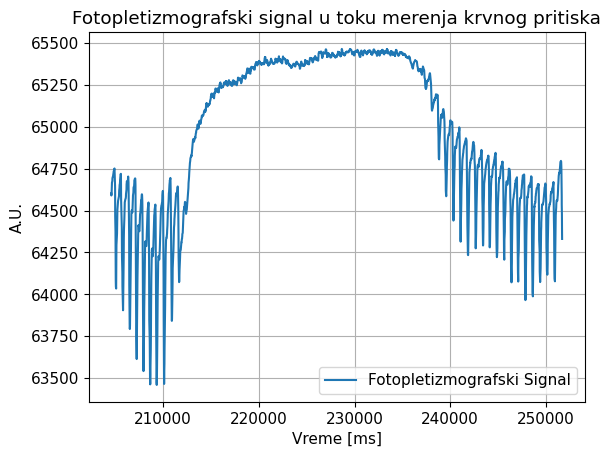

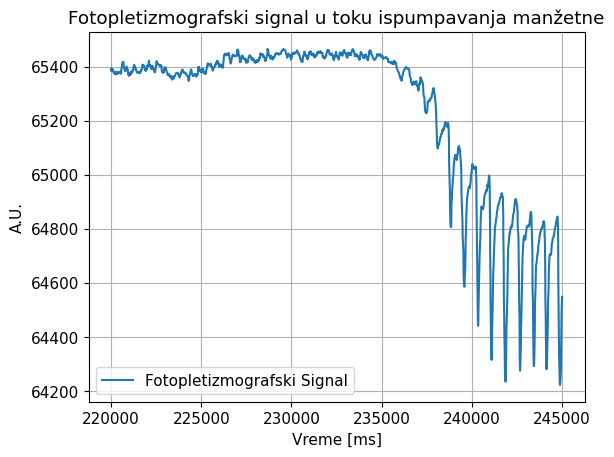

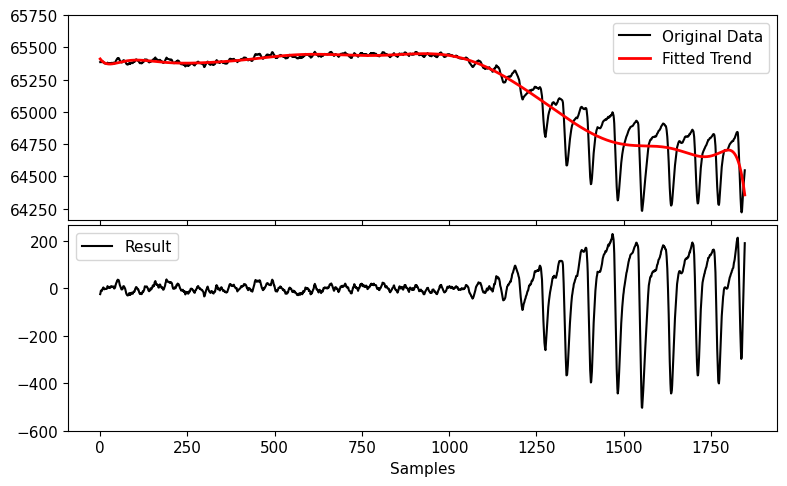

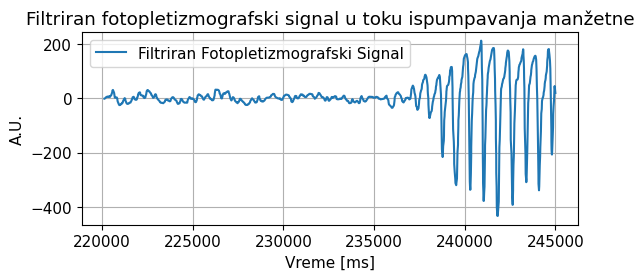

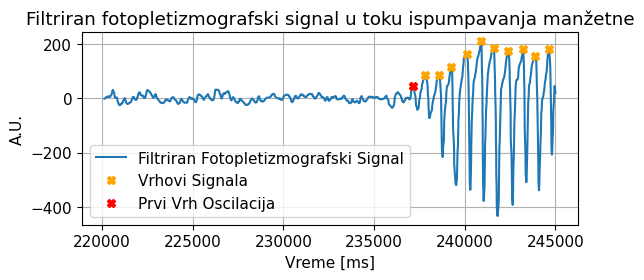

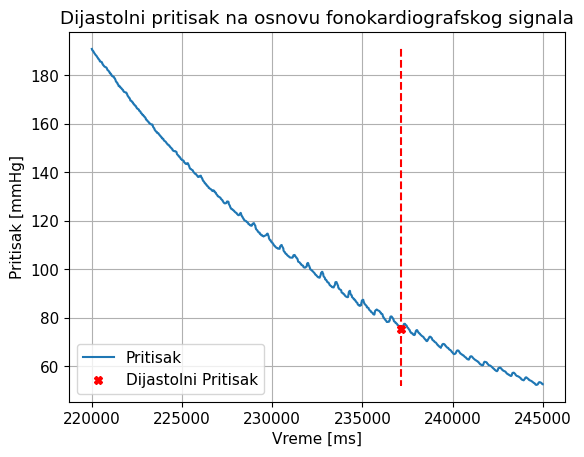

PPG signal results
PPG HR measured during deflation: 80
PPG DIA pressure measurement: 75


In [ ]:
# There are PPG values that repeat both in time and value, using the ppg_time as guidance, delete the doubles
ppg_filtered_data1 = []
ppg_filtered_time1 = []

for i in range(0, len(ppg_raw) - 1):
  # Add the first elements to the array as well as all other first appearences
  if i == 0 or ppg_time[i] != ppg_filtered_time1[-1]:
    ppg_filtered_data1.append(ppg_raw[i])
    ppg_filtered_time1.append(ppg_time[i])

window_size = 10
ppg_filtered_data = []
ppg_filtered_time = ppg_filtered_time1[window_size :]

for i in range(window_size, len(ppg_filtered_data1)):
  ppg_filtered_data.append(sum(ppg_filtered_data1[i : i + window_size]) / window_size)

ppg_filtered_data = ppg_filtered_data[: -100]
ppg_filtered_time = ppg_filtered_time[: -100]

# Figure 1 - PPG signal during the BPM routine
fig_ppg1, ax_ppg1 = plt.subplots()
ax_ppg1.plot(ppg_filtered_time, ppg_filtered_data, label = 'Fotopletizmografski Signal')
ax_ppg1.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Fotopletizmografski signal u toku merenja krvnog pritiska')
ax_ppg1.legend()
ax_ppg1.grid(which='both')

#PPG signal analysis during the cuff deflation
ppg_deflation_data = []
ppg_deflation_time = []
for i in range(0, len(ppg_filtered_data)):
    if ppg_filtered_time[i] >= t_deflation_start and ppg_filtered_time[i] <= t_deflation_stop:
      ppg_deflation_data.append(ppg_filtered_data[i])
      ppg_deflation_time.append(ppg_filtered_time[i])

# Figure 2 - PPG signal during the CUFF deflation
fig_ppg2, ax_ppg2 = plt.subplots()
ax_ppg2.plot(ppg_deflation_time, ppg_deflation_data, label = 'Fotopletizmografski Signal')
ax_ppg2.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Fotopletizmografski signal u toku ispumpavanja manžetne')
ax_ppg2.legend()
ax_ppg2.grid(which='both')

# Detrending the PPG function
ppg_obspy_data = obspy.read()[0].filter('highpass', freq = 1)
ppg_obspy_data.data = np.array(ppg_deflation_data)
ppg_detrended_function = polynomial(ppg_obspy_data.data, order = 15, plot = True)

# Additional data filtering
window_size = 10
ppg_detrented_filtered_data = []
ppg_detrented_filtered_time = ppg_deflation_time[window_size :]
for i in range(window_size, len(ppg_detrended_function)):
  ppg_detrented_filtered_data.append(sum(ppg_detrended_function[i : i + window_size]) / window_size)

# Figure 3 - Detrended PPG signal during cuff deflation
fig_ppg3, ax_ppg3 = plt.subplots()
ax_ppg3.set_aspect(15)
ax_ppg3.plot(ppg_detrented_filtered_time, ppg_detrented_filtered_data, label = 'Filtriran Fotopletizmografski Signal')
ax_ppg3.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Filtriran fotopletizmografski signal u toku ispumpavanja manžetne')
ax_ppg3.legend()
ax_ppg3.grid(which='both')

# Peak detection of the PPG signal
ppg_peaks_ids, ppg_peak_properties = find_peaks(ppg_detrented_filtered_data, height = 0, distance = 30, prominence = (80, None))
ppg_peaks_data = []
ppg_peaks_time = []
for peak in ppg_peaks_ids:
  ppg_peaks_data.append(ppg_detrented_filtered_data[peak])
  ppg_peaks_time.append(ppg_detrented_filtered_time[peak])

# Figure 4 - Detrended PPG signal during cuff deflation with Peaks
fig_ppg4, ax_ppg4 = plt.subplots()
ax_ppg4.set_aspect(15)
ax_ppg4.plot(ppg_detrented_filtered_time, ppg_detrented_filtered_data, label = 'Filtriran Fotopletizmografski Signal')
ax_ppg4.plot(ppg_peaks_time, ppg_peaks_data, 'X', label = 'Vrhovi Signala', color = 'orange')
ax_ppg4.plot(ppg_peaks_time[0], ppg_peaks_data[0], 'X', linewidth = 5, color = 'red', label = 'Prvi Vrh Oscilacija')
ax_ppg4.set(xlabel = 'Vreme [ms]', ylabel = 'A.U.', title = 'Filtriran fotopletizmografski signal u toku ispumpavanja manžetne')
ax_ppg4.legend()
ax_ppg4.grid(which='both')

# Calculating the DIA pressure from the PPG signal
t_dia_ppg = ppg_peaks_time[0]
ppg_dia = 0
for i in range(0, len(bpm_deflation_data) - 1):
  if bpm_deflation_time[i] <= t_dia_ppg and bpm_deflation_time[i + 1] > t_dia_ppg:
    ppg_dia = bpm_deflation_data[i]

# Figure 5 - Showing the DIA pressure from the PPG signal
fig_ppg5, ax_ppg5 = plt.subplots()
ax_ppg5.plot(bpm_deflation_time, bpm_deflation_data, label = 'Pritisak')
ax_ppg5.plot(np.ones(len(bpm_deflation_time)) * t_dia_ppg, bpm_deflation_data, '--', color = 'red')
ax_ppg5.plot(t_dia_ppg, ppg_dia, 'X', color = 'red', label = 'Dijastolni Pritisak')
ax_ppg5.set(xlabel = 'Vreme [ms]', ylabel = 'Pritisak [mmHg]', title = 'Dijastolni pritisak na osnovu fonokardiografskog signala')
ax_ppg5.legend()
ax_ppg5.grid(which='both')


plt.show()


# Print out the PPG peaks location
t_dia_ppg = ppg_peaks_time[0]
hr_ppg = 60000 * (len(ppg_peaks_data) - 1) / (ppg_peaks_time[-1] - ppg_peaks_time[0])

# Print out the results
print('PPG signal results')
#print('PPG DIA detected at time: ' + str(t_dia_ppg))
print('PPG HR measured during deflation: ' + str(int(hr_ppg)))
print('PPG DIA pressure measurement: ' + str(int(ppg_dia)))

save_ppg_figs = False

if save_ppg_figs == True:
  fig_ppg1.savefig("PPG_fig1_FotopletizmografskiSignalUTokuMerenjaKrvnogPritiska.png", dpi = 250, bbox_inches='tight')
  fig_ppg2.savefig("PPG_fig2_FotopletizmografskiSignalUTokuIspumpavanjaManzetne.png", dpi = 250, bbox_inches='tight')
  fig_ppg3.savefig("PPG_fig3_FiltriranPPGSignal.png", dpi = 250, bbox_inches='tight')
  fig_ppg4.savefig("PPG_fig4_FiltriranPPGSignal-Vrhovi.png", dpi = 250, bbox_inches='tight')
  fig_ppg5.savefig("PPG_fig5_PPG-IzmerenDijastolniPritisak.png", dpi = 250, bbox_inches='tight')

# ECG

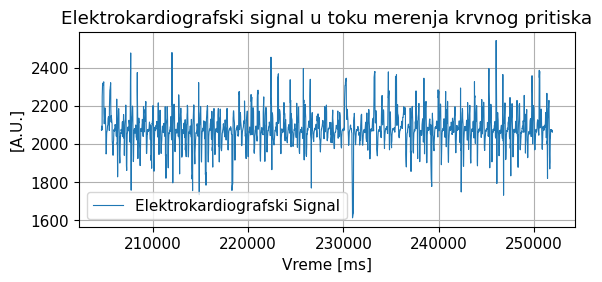

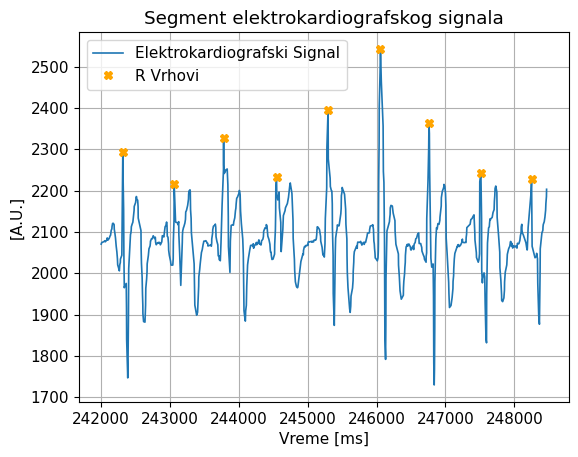

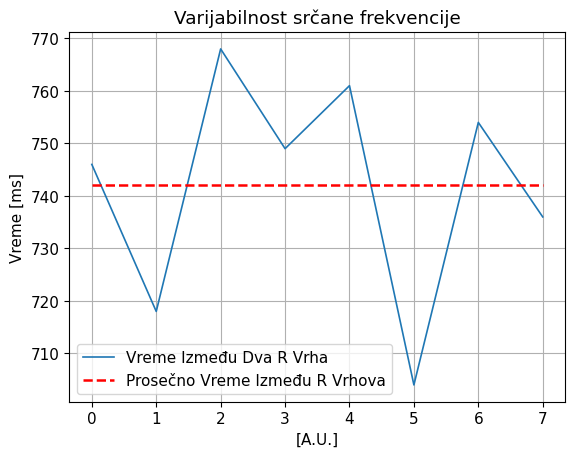

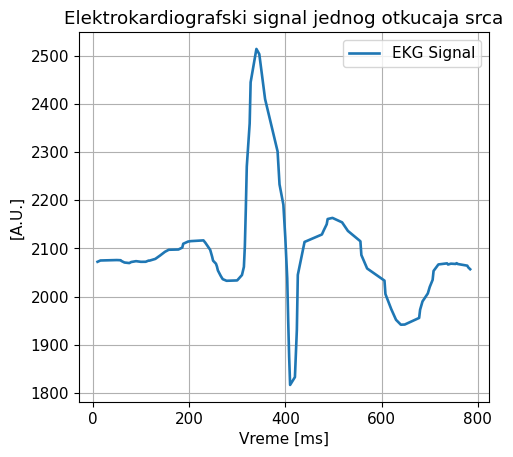

Heart rate calculated based on the ECG is: 80.86253369272237


In [ ]:
# ECG
# Fitlering the ECG data
window_size = 10
ecg_filtered_data = []
ecg_filtered_time = ecg_time[window_size :]
for i in range(window_size, len(ecg_raw)):
  ecg_filtered_data.append(sum(ecg_raw[i : i + window_size]) / window_size)
ecg_filtered_data = ecg_filtered_data[: -100]
ecg_filtered_time = ecg_filtered_time[: -100]

# Figure 1 - ECG data throghout the whole BPM
fig_ecg1, ax_ecg1 = plt.subplots()
ax_ecg1.set_aspect(20)
ax_ecg1.plot(ecg_filtered_time, ecg_filtered_data, linewidth = 0.8, label = 'Elektrokardiografski Signal')
ax_ecg1.set(xlabel = 'Vreme [ms]', ylabel = '[A.U.]', title = 'Elektrokardiografski signal u toku merenja krvnog pritiska')
ax_ecg1.legend()
ax_ecg1.grid(which='both')

# Extracing a piece of data for analysis
ecg_analysis_start  = 242000
ecg_analysis_stop   = 248500
ecg_analysis_data   = []
ecg_analysis_time   = []
for i in range(0, len(ecg_filtered_data)):
  if ecg_filtered_time[i] >= ecg_analysis_start and ecg_filtered_time[i] <= ecg_analysis_stop:
    ecg_analysis_data.append(ecg_filtered_data[i])
    ecg_analysis_time.append(ecg_filtered_time[i])

# Peak detection of the ECG signal
ecg_peaks_ids, ecg_peak_properties = find_peaks(ecg_analysis_data, height = 0, distance = 40, prominence = (80, None))
ecg_peaks_data = []
ecg_peaks_time = []
for peak in ecg_peaks_ids:
  ecg_peaks_data.append(ecg_analysis_data[peak])
  ecg_peaks_time.append(ecg_analysis_time[peak])

# Figure 2 - Part of ECG Data
fig_ecg2, ax_ecg2 = plt.subplots()
ax_ecg2.set_aspect(6)
ax_ecg2.plot(ecg_analysis_time, ecg_analysis_data, linewidth = 1.2, label = 'Elektrokardiografski Signal')
ax_ecg2.plot(ecg_peaks_time, ecg_peaks_data, 'X', linewidth = 1, color = 'orange', label = 'R Vrhovi')
ax_ecg2.set(xlabel = 'Vreme [ms]', ylabel = '[A.U.]', title = 'Segment elektrokardiografskog signala')
ax_ecg2.legend()
ax_ecg2.grid(which='both')

# Calculating the delta time between R peaks
ecg_time_deltas = []
for i in range(1, len(ecg_peaks_time)):
  ecg_time_deltas.append(ecg_peaks_time[i] - ecg_peaks_time[i - 1])
mean_pulse_time = sum(ecg_time_deltas) / len(ecg_time_deltas)

# Figure 3 - HRV
fig_ecg3, ax_ecg3 = plt.subplots()
#ax_ecg3.set_aspect(10)
ax_ecg3.plot(ecg_time_deltas, linewidth = 1.2, label = 'Vreme Između Dva R Vrha')
ax_ecg3.plot(np.linspace(0, len(ecg_time_deltas) - 1, len(ecg_time_deltas)), np.ones(len(ecg_time_deltas)) * mean_pulse_time, '--', color = 'red', linewidth = 1.8, label = 'Prosečno Vreme Između R Vrhova')
ax_ecg3.set(xlabel = '[A.U.]', ylabel = 'Vreme [ms]', title = 'Varijabilnost srčane frekvencije')
ax_ecg3.legend()
ax_ecg3.grid(which='both')

# Extracting a single heart beat out of the signal
ecg_beat_start  = 245700
ecg_beat_stop   = 246600
ecg_single_data   = []
ecg_single_time   = []
for i in range(0, len(ecg_analysis_data)):
  if ecg_analysis_time[i] >= ecg_beat_start and ecg_analysis_time[i] <= ecg_beat_stop:
    ecg_single_data.append(ecg_analysis_data[i])
    ecg_single_time.append(ecg_analysis_time[i])
    if len(ecg_single_time) > 1:
      ecg_single_time[-1] -= ecg_single_time[0]
ecg_single_time[0] = 0

# Additional Filtering
window_size = 2
ecg_single_filtered_data = []
ecg_single_filtered_time = ecg_single_time[window_size :]
for i in range(window_size, len(ecg_single_data)):
  ecg_single_filtered_data.append(sum(ecg_single_data[i : i + window_size]) / window_size)
ecg_single_filtered_data = ecg_single_filtered_data[: -10]
ecg_single_filtered_time = ecg_single_filtered_time[: -10]

# Figure 4 - Single Heartbeat
fig_ecg4, ax_ecg4 = plt.subplots()
ax_ecg4.set_aspect(1)
ax_ecg4.plot(ecg_single_filtered_time, ecg_single_filtered_data, linewidth = 1.9, label = 'EKG Signal')
ax_ecg4.set(xlabel = 'Vreme [ms]', ylabel = '[A.U.]', title = 'Elektrokardiografski signal jednog otkucaja srca')
ax_ecg4.legend()
ax_ecg4.grid(which='both')

plt.show()

# Calculating the HR
hr_ecg = 60000 * (len(ecg_peaks_data) - 1) / (ecg_peaks_time[-1] - ecg_peaks_time[0])
print('Heart rate calculated based on the ECG is: ' + str(hr_ecg))

save_ecg_figs = True

if save_ecg_figs == True:
  fig_ecg1.savefig("ECG_fig1_EKG_CeloMerenje.png", dpi = 250, bbox_inches='tight')
  fig_ecg2.savefig("ECG_fig2_EKG_DeoMerenja.png", dpi = 250, bbox_inches='tight')
  fig_ecg3.savefig("ECG_fig3_EKG_HRV.png", dpi = 250, bbox_inches='tight')
  fig_ecg4.savefig("ECG_fig4_EKG_JedanOtkucaj.png", dpi = 250, bbox_inches='tight')

In [ ]:
# This code serves just to print out all of the results

# BPM
print('BPM results using only the pressure sensor:')
print('SYS pressure:        ' + str(bpm_sys_val))
print('DIA pressure:        ' + str(bpm_dia_val))
print('MAP:                 ' + str(bpm_map))

print('--------------------------------------------------------------')

# Pressure + AUX + PPG
print('BPM results using pressure, PPG and AUX measurements:')
print('SYS pressure (AUX):  ' + str(aux_sys))
print('DIA pressure (PPG):  ' + str(ppg_dia ))

print('--------------------------------------------------------------')

print('Heart rate results from different measurements')
print('Heart rate BPM:      ' + str(bpm_hr))
print('Heart rate PPG:      ' + str(hr_ppg))
print('Heart rate AUX:      ' + str(hr_aux))
print('Heart rate ECG:      ' + str(hr_ecg))

BPM results using only the pressure sensor:
SYS pressure:        132.36512
DIA pressure:        79.40248799999999
MAP:                 91.149752
--------------------------------------------------------------
BPM results using pressure, PPG and AUX measurements:
SYS pressure (AUX):  143.71260800000002
DIA pressure (PPG):  75.35091200000002
--------------------------------------------------------------
Heart rate results from different measurements
Heart rate BPM:      78.28518173345759
Heart rate PPG:      80.03201280512205
Heart rate AUX:      80.09858287122613
Heart rate ECG:      80.86253369272237


# Pressure Sensor Calibration

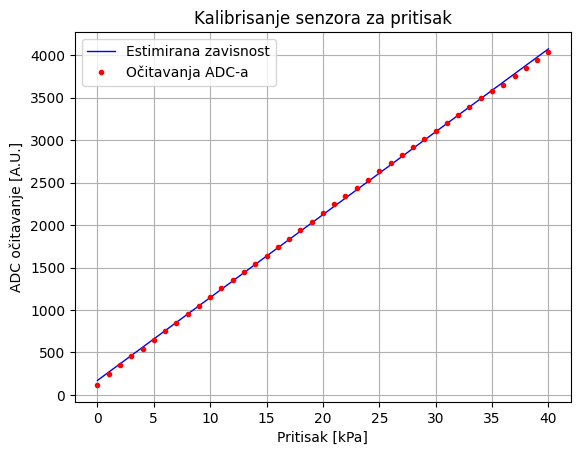

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

adc_data = [118.25 ,246, 351.25 ,458, 546 ,650.25, 754.75, 852.5, 948, 1046, 1149, 1254, 1353.25, 1448.25, 1541.25, 1636.5, 1740.25, 1839.25, 1943.25, 2036, 2137.75, 2242.5, 2339, 2440.75, 2535.75, 2631, 2726.75, 2822.5, 2915.5, 3015.75, 3112, 3206.75, 3300, 3393.5, 3491.25, 3577.75, 3652.75, 3754.75, 3845, 3938.75, 4032.5]
pressure_data = np.linspace(0, len(adc_data) - 1, len(adc_data))
k = 0.07688
n = -13.16872
k1 = 13.00728
n1 = 171.2892
coef_kpa_mmhg = 7.50062

calculated_adc = []

for i in range(0, len(pressure_data)):
  calculated_adc.append(coef_kpa_mmhg * k1 * pressure_data[i] + n1)

# Figure 4 - Single Heartbeat
fig_cal, ax_cal = plt.subplots()
#ax_cal.set_aspect(1)
ax_cal.plot(pressure_data, calculated_adc, color = 'blue', linewidth = 1.0, label = 'Estimirana zavisnost')
ax_cal.plot(pressure_data, adc_data, '.', color = 'red', linewidth = 0.1, label = 'Očitavanja ADC-a')
ax_cal.set(ylabel = 'ADC očitavanje [A.U.]', xlabel = 'Pritisak [kPa]', title = 'Kalibrisanje senzora za pritisak')
ax_cal.legend()
ax_cal.grid(which='both')

fig_cal.savefig("GrafikKalibracije.png", dpi = 250, bbox_inches='tight')

plt.show()
